In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 

matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, trainDenoising, OrthoLoss, init_train_hist
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


## Set configuration

In [73]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg.copy_and_resolve_references()

#Set model specific config
n_hidden = 10
cfg.enc_hidden_dim = list(np.linspace(cfg.obs_dim,cfg.factor_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim = list(np.linspace(cfg.factor_dim,cfg.obs_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.enc_activation = nn.Sigmoid
cfg.dec_activation = nn.Sigmoid
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = True

#set experiment specifig training params
cfg.lr = 0.0008
cfg.n_epoch = 50
cfg.max_iter = 10
cfg.saved_index = 30
cfg.use_default_data  = True
cfg.batch_size = 128

cfg.T_train = 100

## Obtain Data
Obtain the simulated $y$ and $f$

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(100, 50) (1024, 50) (15260, 50)


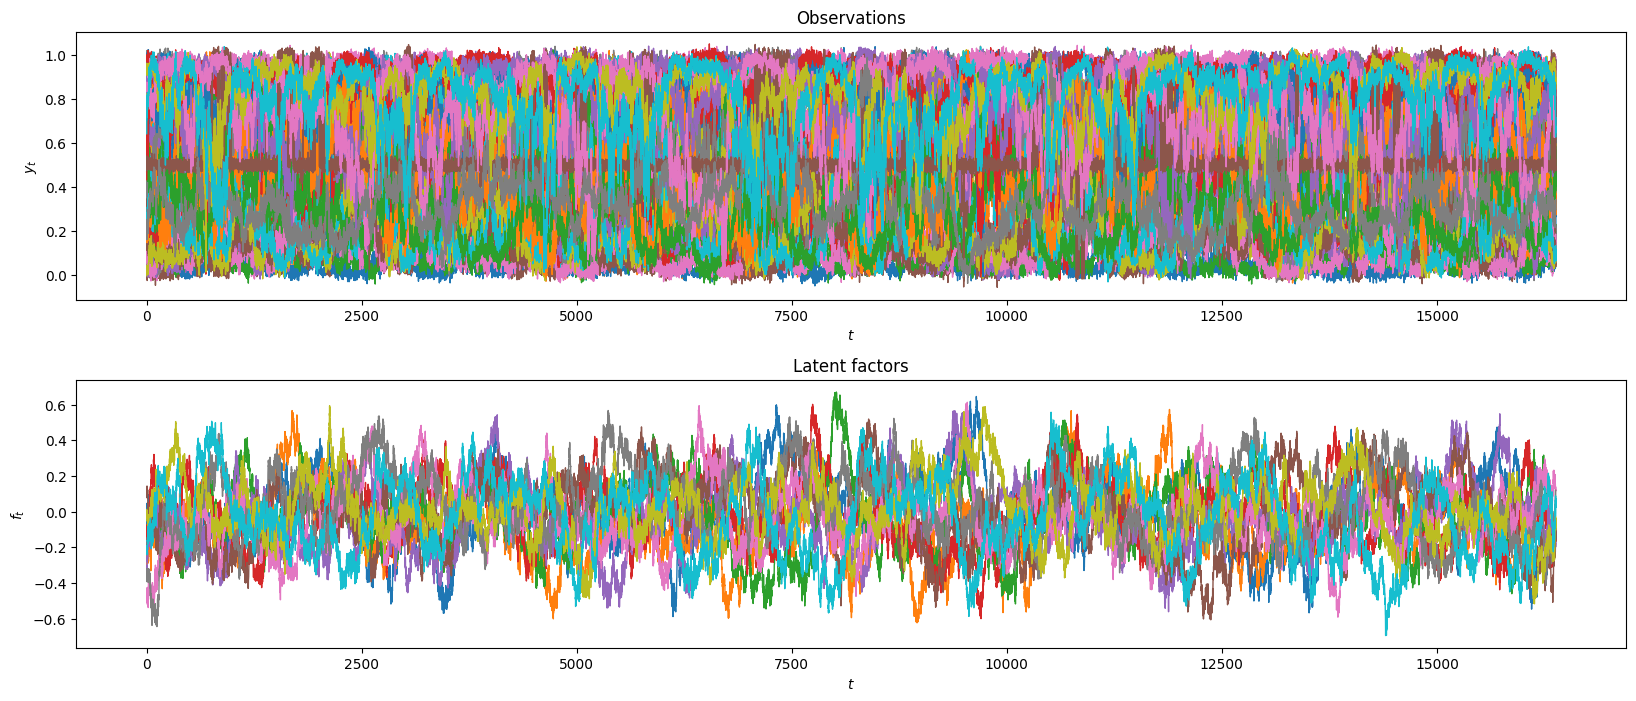

In [74]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=False, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [714]:
#torch.save(dec, '../DGP/saved/dec_5.pt')
#np.save(arr=y, file='../DGP/saved/y_5.npy')
#np.save(arr=f, file='../DGP/saved/f_5.npy')

## Estimate autoencoder model

In [75]:
n_hidden = 3
cfg.enc_hidden_dim = list(np.linspace(cfg.obs_dim,cfg.factor_dim,n_hidden+2).astype(int)) #pyramid arch
cfg.dec_hidden_dim  = [cfg.factor_dim,cfg.obs_dim]#= list(np.linspace(cfg.factor_dim,cfg.obs_dim,n_hidden+2).astype(int)) #pyramid arch
#cfg.dec_hidden_dim= [cfg.factor_dim, cfg.obs_dim]
cfg.enc_activation = nn.Sigmoid
cfg.dec_activation = nn.Identity
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = False
cfg.batch_size = 256*1

dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear, dropout =0.0)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear, dropout =0.0)
mod = AutoEncoder(enc=enc, dec=dec)
print(mod)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T).initialize()
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]
#criterion = OrthoLoss(enc, alpha=10)
criterion = nn.MSELoss()
train_hist = init_train_hist(metrics)

AutoEncoder(
  (enc): Encoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=50, out_features=40, bias=True)
      (activation_0): Sigmoid()
      (linear_1): Linear(in_features=40, out_features=30, bias=True)
      (activation_1): Sigmoid()
      (linear_2): Linear(in_features=30, out_features=20, bias=True)
      (activation_2): Sigmoid()
      (linear_3): Linear(in_features=20, out_features=10, bias=True)
      (activation_3): Sigmoid()
    )
  )
  (dec): Decoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=10, out_features=50, bias=True)
      (activation_0): Identity()
    )
  )
)
Number of trainable paramaters 4650


/home/ubuntu/Thesis/Simulation/../BasicAutoEncoder/model.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


In [90]:
cfg.lr = 0.0003
cfg.max_iter = 200
cfg.n_epoch = 100
train_hist = trainMCMC(X_train=y_train, criterion=criterion, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter, train_hist=train_hist)
#train_hist = trainDenoising(X_train=y_train, criterion=criterion, X_val = y_val, model=mod, n_epoch=cfg.n_epoch*cfg.max_iter, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, train_hist=train_hist)

print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


torch.Size([100, 50]) torch.Size([1024, 50])
1 0.00046304648276418458276418455
2 0.00046397931873798371873798374
3 0.00047197425737977035737977037
4 0.00046151559217832989217832985
5 0.00047075370093807580093807585
6 0.00047132821055129171055129176
7 0.00046906125498935585498935586
8 0.00049853324890136724890136726
9 0.00047364243073388934073388934
10 0.0004734337271656841716568413
11 0.0004588214796967804469678044
12 0.0004546569834928959649289596
13 0.0004679397388827055788270557
14 0.0004566518182400614824006145
15 0.0004643296997528523975285234
16 0.0004742284072563052725630523
17 0.0004482039366848767668487673
18 0.0004556959902402013524020135
19 0.0004867835377808663778086696
20 0.0004680181446019564460195684
21 0.0004629540198948234389482343
22 0.0004605766152963042529630426
23 0.0004492778680287301502873015
24 0.0004609952738974243489742434
25 0.0004618812527041882370418823
26 0.0004658212419599294795992947
27 0.0004767740028910339289103396
28 0.0004852573329117149291171495
29 

In [93]:
EXPERIMENT_NAME = 'assymetric_T100'
logResults(train_hist, mod, cfg, EXPERIMENT_NAME)

./Results/30/13_assymetric_T100_06032023_23:47:02


### Train & val loss

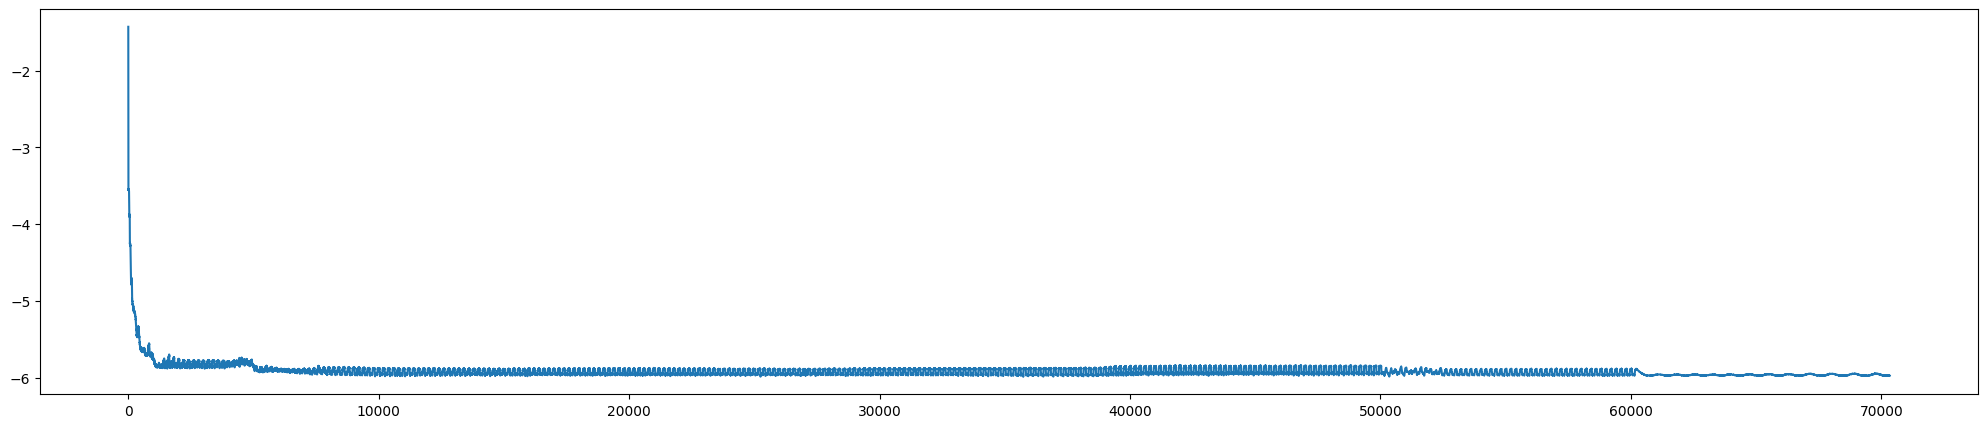

In [46]:
plt.plot(np.log(train_hist['val_loss']))

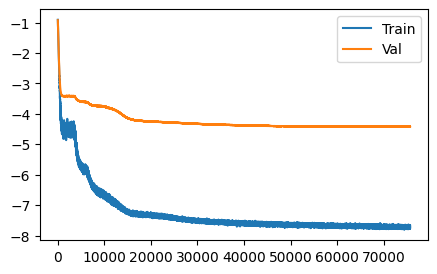

In [91]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

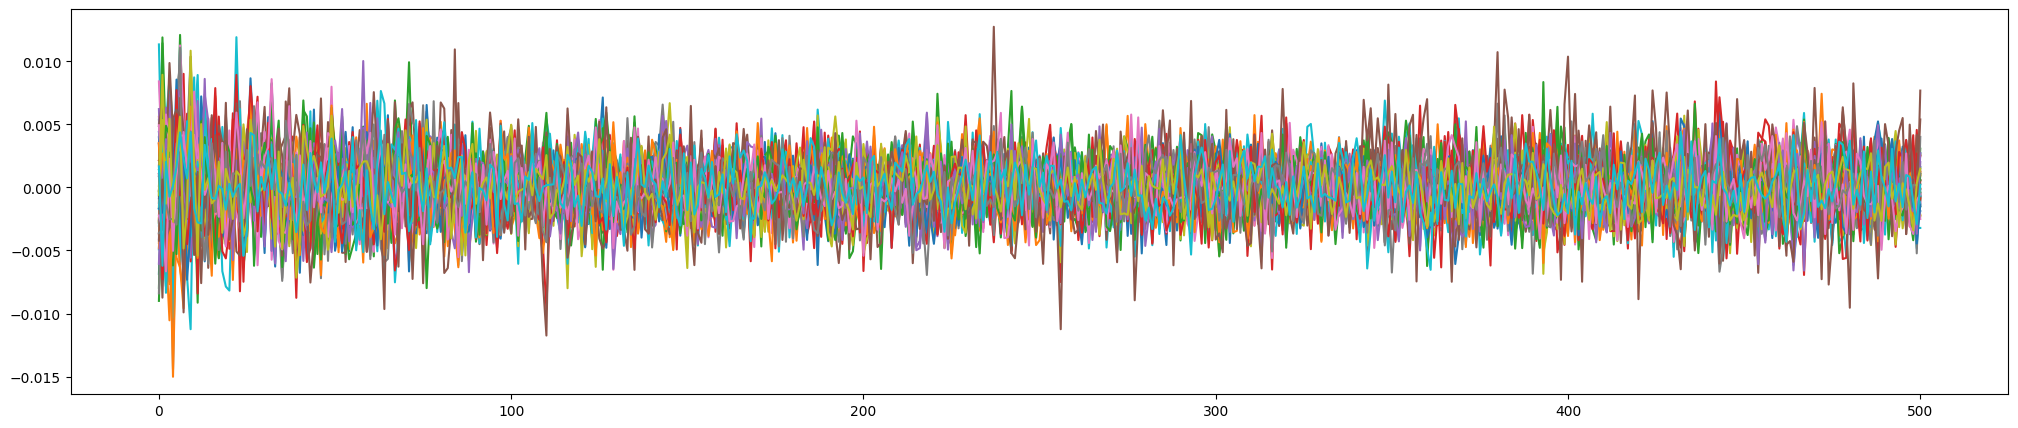

In [36]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

[0.00072638 0.00042525 0.00065235 0.00095065 0.00085611 0.0004154
 0.00056479 0.00051654 0.00051771 0.00107211 0.00053623 0.00062026
 0.00114542 0.00063498 0.00082775 0.0004395  0.00071428 0.00045894
 0.00065111 0.00040331 0.00071148 0.00049392 0.00046311 0.00110717
 0.00034194 0.0010985  0.00100227 0.0003618  0.00057725 0.00038748
 0.00043323 0.00064457 0.00063553 0.00075888 0.00038628 0.000382
 0.00035686 0.00158951 0.00042811 0.00041213 0.00056121 0.00095582
 0.00171592 0.00062757 0.00059719 0.0009928  0.00072585 0.00044977
 0.00108686 0.0007412 ]


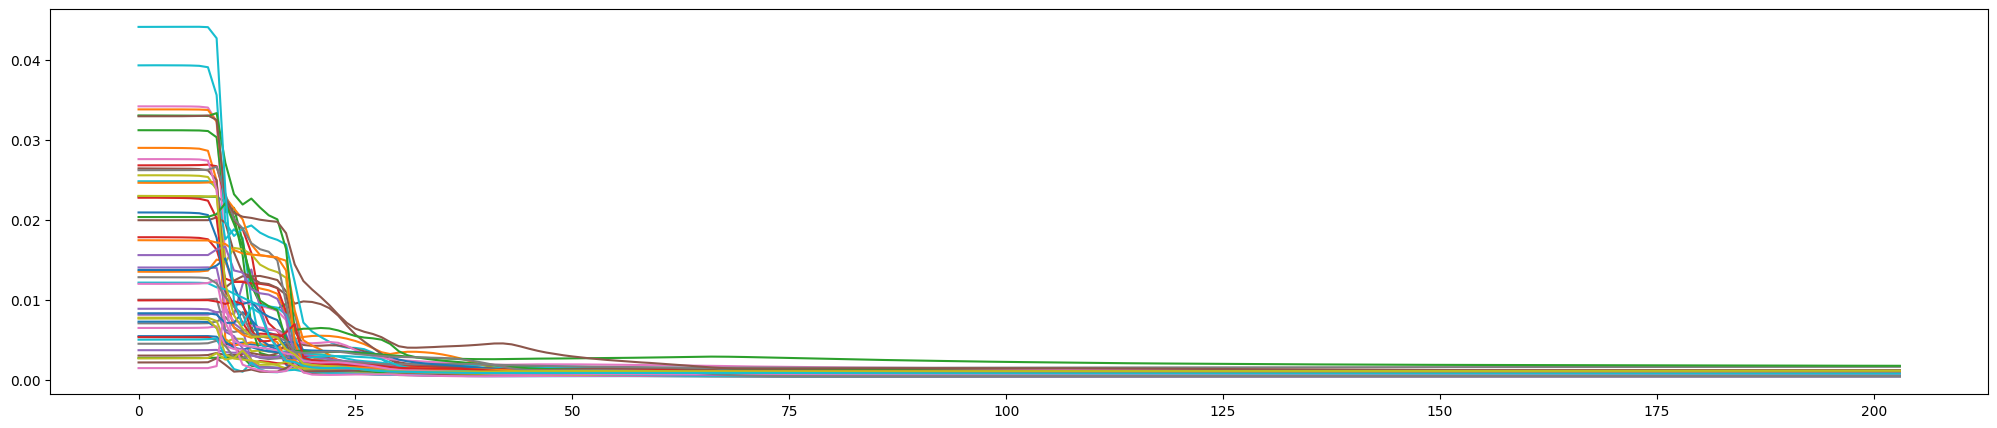

In [70]:
plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
print([np.diag(_) for _ in errorProcess.fit_hist['cov']][-1])

### Reconstruction of y

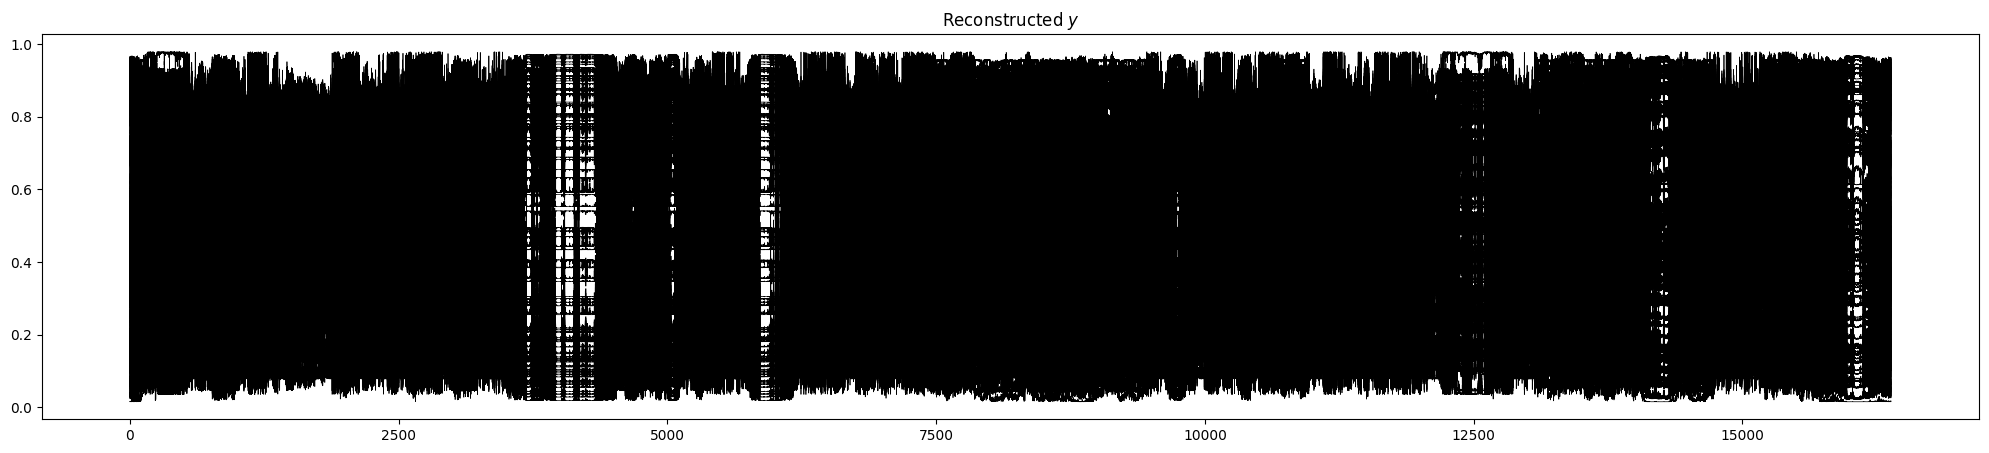

In [785]:
mod.eval()
plot_reconstructed_y(mod, y[:], c='black', linewidth=0.5)
#plt.plot(y, c='black', linewidth=0.5);


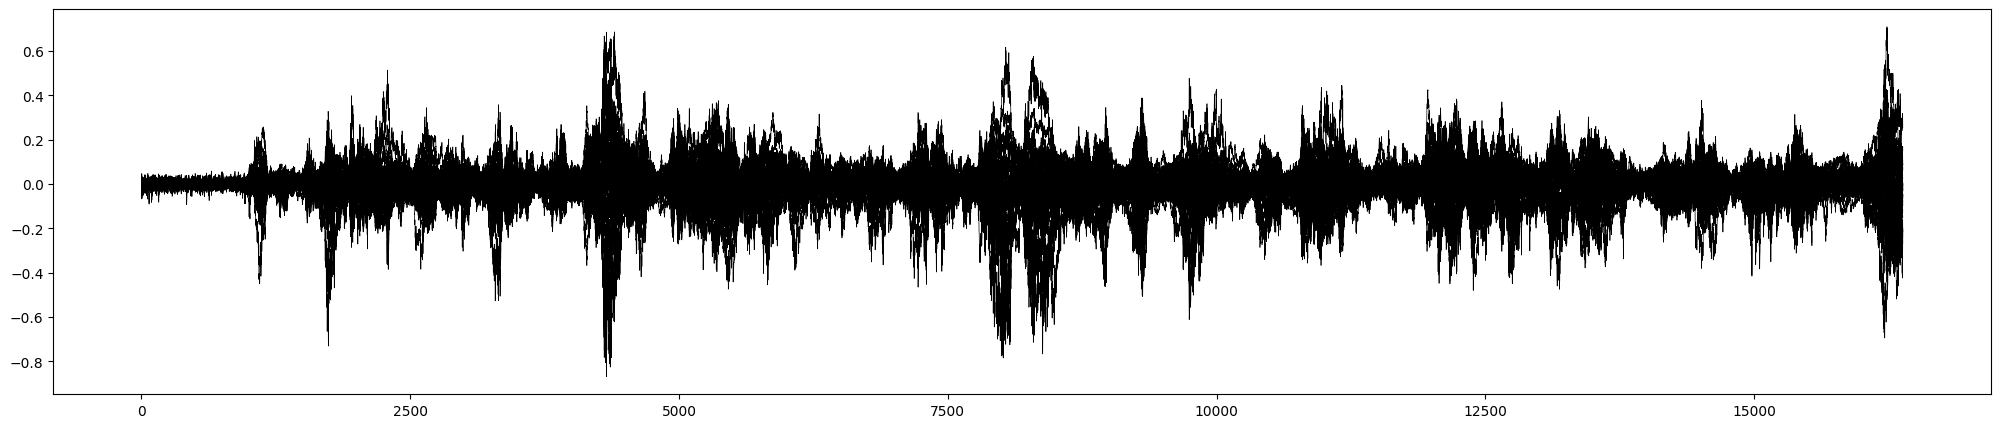

In [903]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y[:], c='black', linewidth=0.5);

### Factor estimation

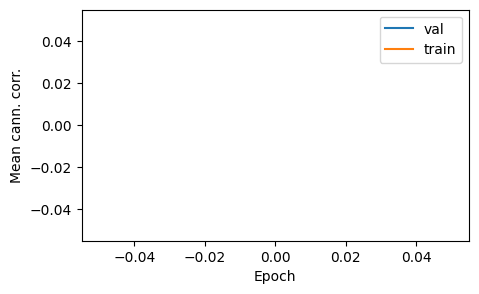

In [43]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [92]:
mod.eval()
f_train_hat = mod.cpu().enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.cpu().enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  
print("cc R2 on test data: ", cca.score(f_test_hat, f_test))  

from evaluation import bootstrapCCA
#bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
#print("Bootstrapped cca: mean, std, 95%ci", (np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975])))

y_test_hat = mod(torch.Tensor(y_test).float()).detach().numpy()
print(f'Mse on test data: {np.mean((y_test_hat - y_test)**2)}')





cc on train data: 0.7285009135343714
cc on test data: 0.6525827610499083
cc on train data:  0.7285008433318827
cc on test data:  0.6525826651030056
cc R2 on test data:  0.43452911104778186


ModuleNotFoundError: No module named 'tqdm'

0.7564674299735028 0.004272081618319704 [0.7484383  0.76522837]


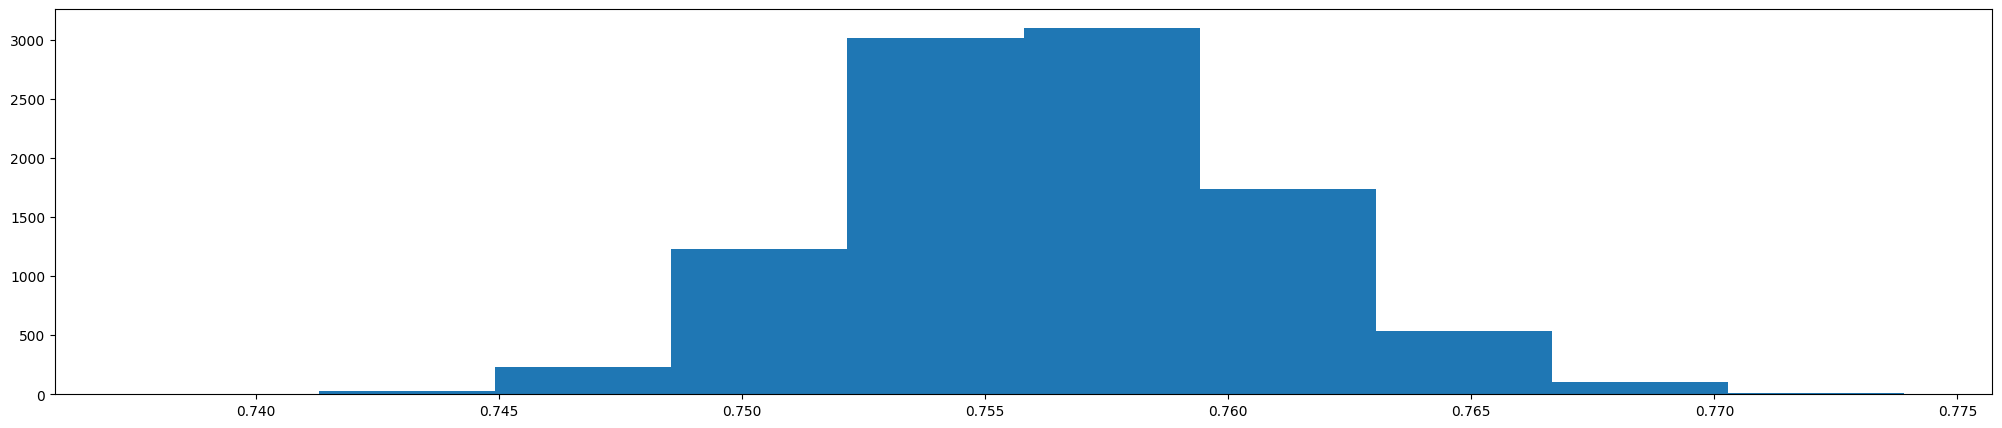

In [974]:
from evaluation import bootstrapCCA
bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
print(np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975]))
plt.hist(bs);

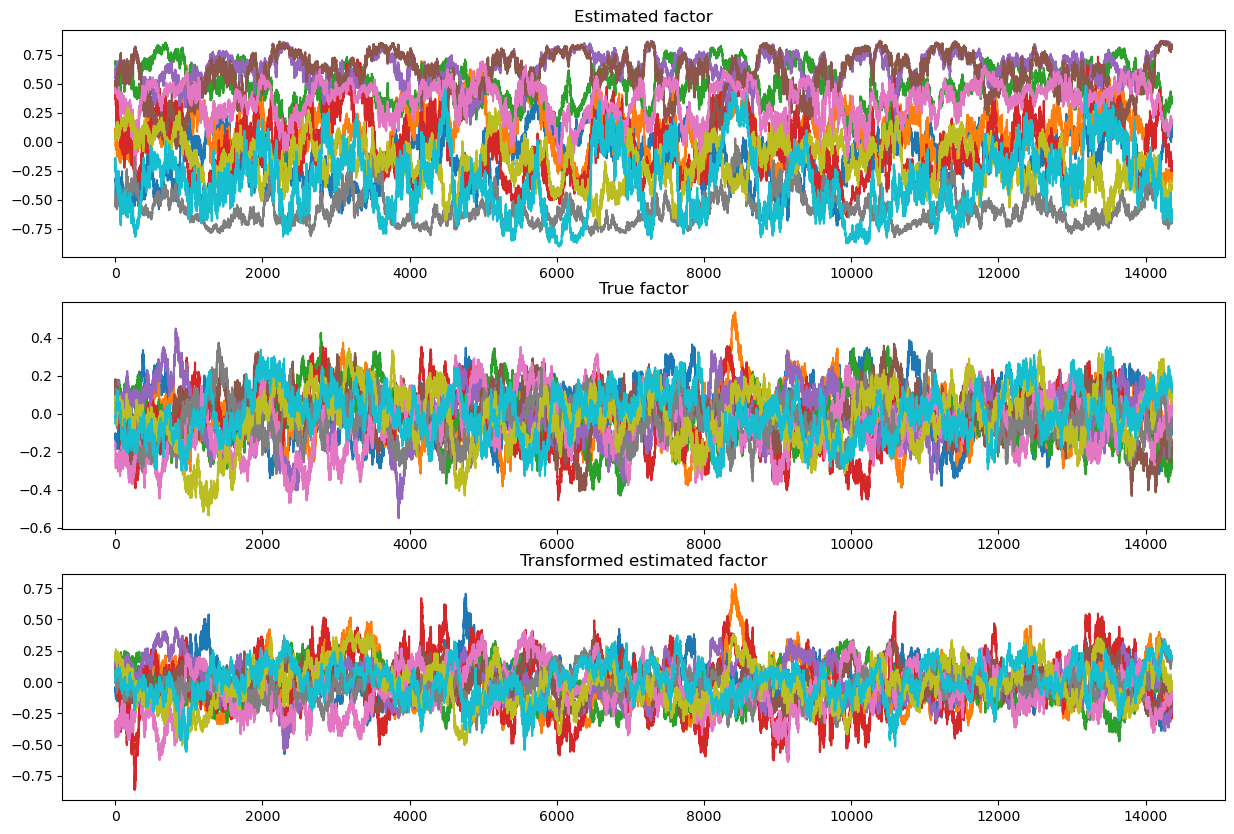

In [31]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

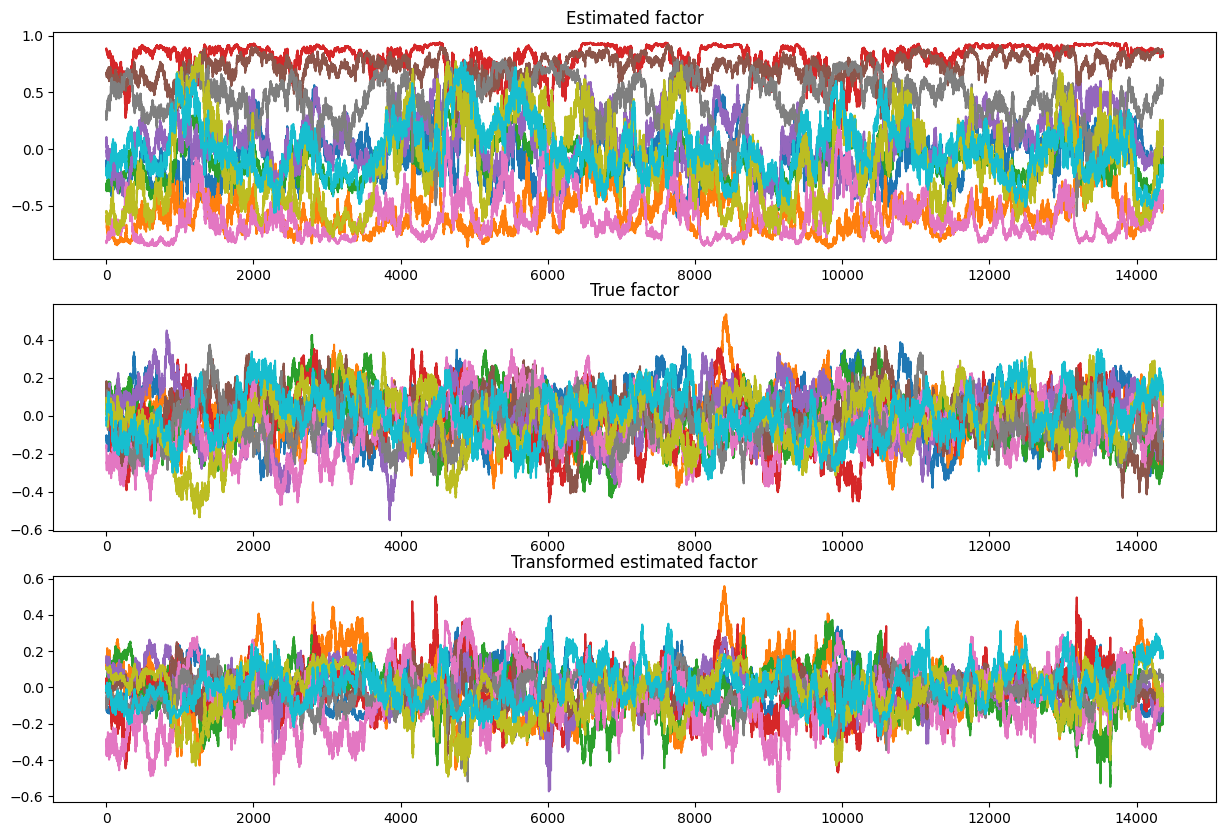

In [837]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

In [213]:
y_test.shape

(14360, 100)

In [211]:
y_test_pred.shape

(7168, 100)

In [212]:
y_test_pred - y_test

ValueError: operands could not be broadcast together with shapes (7168,100) (14360,100) 

### Forecast

1-step ahead  FMSE on the test set: 0.007049019448459148


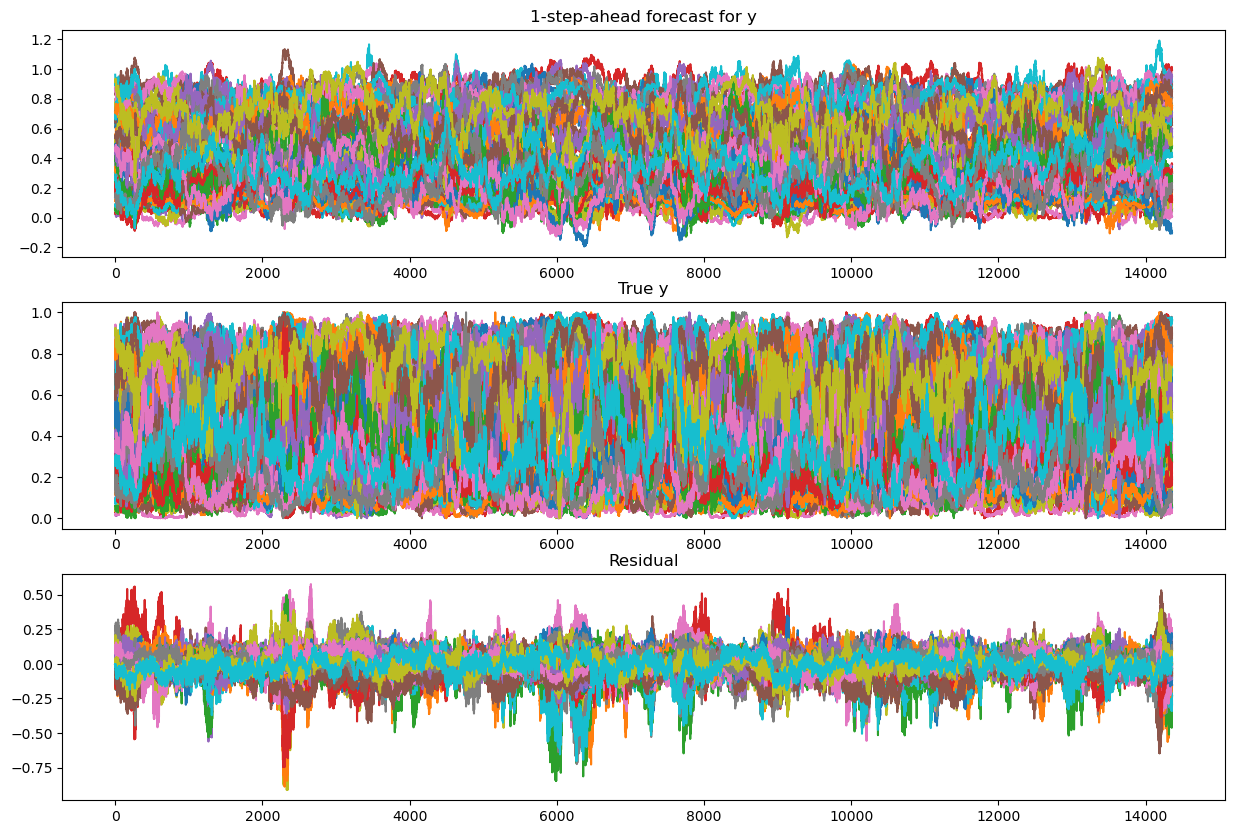

In [32]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
#f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_train_hat, f_val_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[cfg.T_train + cfg.T_val - 2:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

1-step ahead  FMSE on the test set: 0.001120314234867692


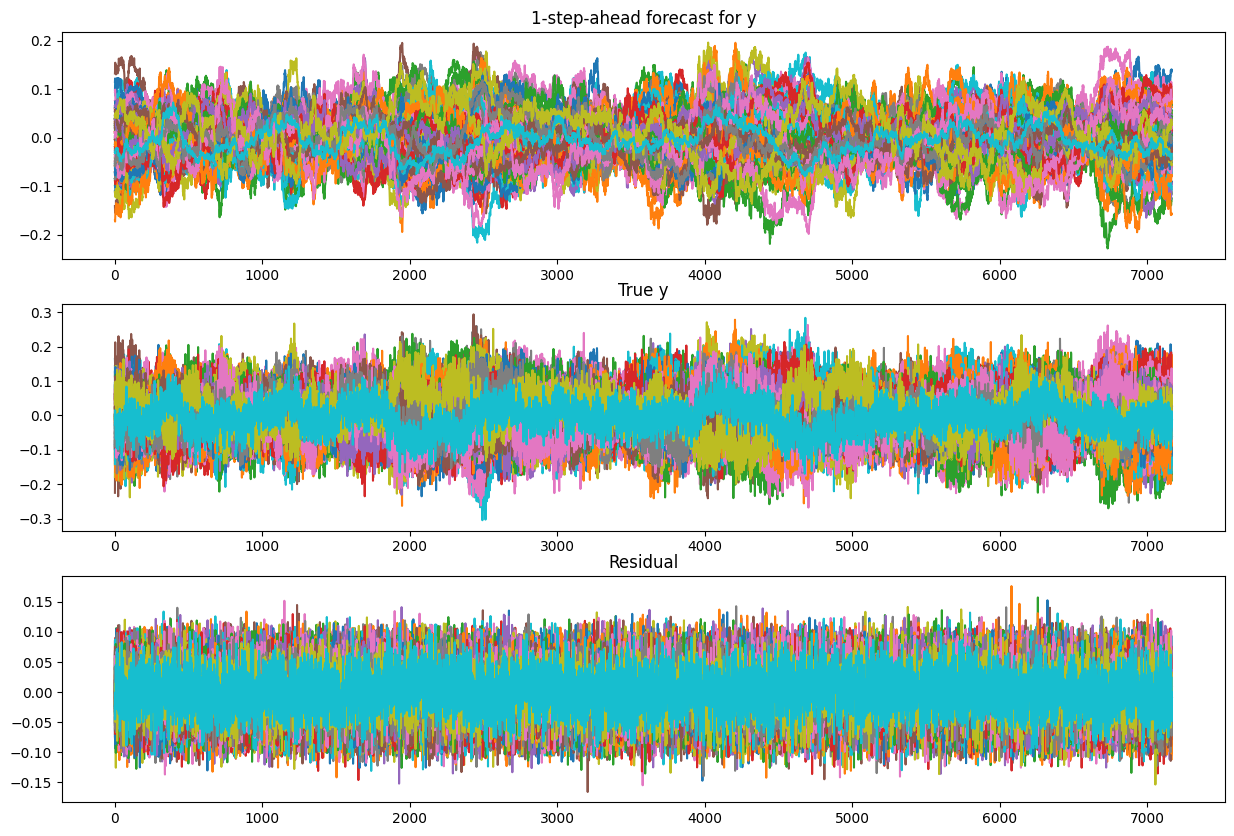

In [ ]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

In [ ]:
from dm import in_MDM_test
e1 = np.sum(y_test_pred[0:200]-y_test[0:200],axis=1)
e2 = np.sum(y_test_pred[200:400]-y_test[200:400],axis=1)
d = np.vstack([e1,e2])
in_MDM_test(d, q=3, statistic='Sc')


[array([-4.83519267, -0.88930998]),
 {'statistic': array([[24.69429677]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[4.34211768e-06]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 4.79529500e-01 -9.63633358e-02  1.78181291e-01  1.16548568e-01\n   1.31618828e-01 -4.70486283e-02 -4.49910820e-01 -3.44798893e-01\n  -5.85365057e-01 -1.58060282e-01  3.49326044e-01  2.09747851e-01\n  -5.88828027e-02  7.58422166e-02  7.17078984e-01  5.64274907e-01\n   8.31719577e-01 -4.11872178e-01  2.06792831e-01  2.98056751e-02\n   1.44059241e-01  5.46021879e-01 -1.76732197e-01 -5.81284016e-02\n  -7.22203672e-01 -7.15541005e-01 -9.72125113e-01 -5.39268851e-01\n  -2.25835085e-01 -3.37127507e-01 -2.69950330e-01 -8.04915190e-01\n  -2.16774508e-01  9.71347690e-02  9.16699469e-02 -4.30077851e-01\n  -1.27607846e+00 -8.94060969e-01  4.18439329e-01  2.32095599e-01\n  -2.89919317e-01 -1.82350159e-01  3.39898407e-01 -3.65081489e-01\n  -5

In [ ]:
a = np.array([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
b = np.array([1,0,0,0,0,2,0,0,0,1,0,0,0,0])
realized =  np.array([2,2,2,2,2,2,2,2,2,2,2,2,2,2])
d = np.stack([(a-realized)**2, (b-realized)**2])
q = 3
in_MDM_test(d, q=3, statistic='Sc')


[array([2.20895601, 0.85136117]),
 {'statistic': array([[2.82956626]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[0.2429783]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 1  0  1  4  9 16 25  1  0  1  4  9 16 25]\n [ 1  4  4  4  4  0  4  4  4  1  4  4  4  4]]'}]

In [ ]:
np.sum(y_test_pred-y_test,axis=1).shape

(7168,)

In [ ]:
y_test_pred[0:300].shape

(300, 100)

In [ ]:
np.concatenate([y_val,y_test][0:100]).shape

(8192, 100)

In [ ]:
from evaluation import expandingWindowForecast
ewf = expandingWindowForecast(mod=mod,y_train = y_train, y_test = np.concatenate([y_val,y_test])[0:20])

(1, 100)
(8193, 100) (19, 100)
(1, 100)
(8194, 100) (18, 100)
(1, 100)
(8195, 100) (17, 100)
(1, 100)
(8196, 100) (16, 100)
(1, 100)
(8197, 100) (15, 100)
(1, 100)
(8198, 100) (14, 100)
(1, 100)
(8199, 100) (13, 100)
(1, 100)
(8200, 100) (12, 100)
(1, 100)
(8201, 100) (11, 100)
(1, 100)
(8202, 100) (10, 100)
(1, 100)
(8203, 100) (9, 100)
(1, 100)
(8204, 100) (8, 100)
(1, 100)
(8205, 100) (7, 100)
(1, 100)
(8206, 100) (6, 100)
(1, 100)
(8207, 100) (5, 100)
(1, 100)
(8208, 100) (4, 100)
(1, 100)
(8209, 100) (3, 100)
(1, 100)
(8210, 100) (2, 100)
(1, 100)
(8211, 100) (1, 100)
(1, 100)
(8212, 100) (0, 100)


In [ ]:
np.mean(ewf,axis=1).shape

(20, 100)

In [ ]:
ewf[0].shape

(1, 100)

In [ ]:
np.vstack(ewf).shape

(20, 100)

(100,)


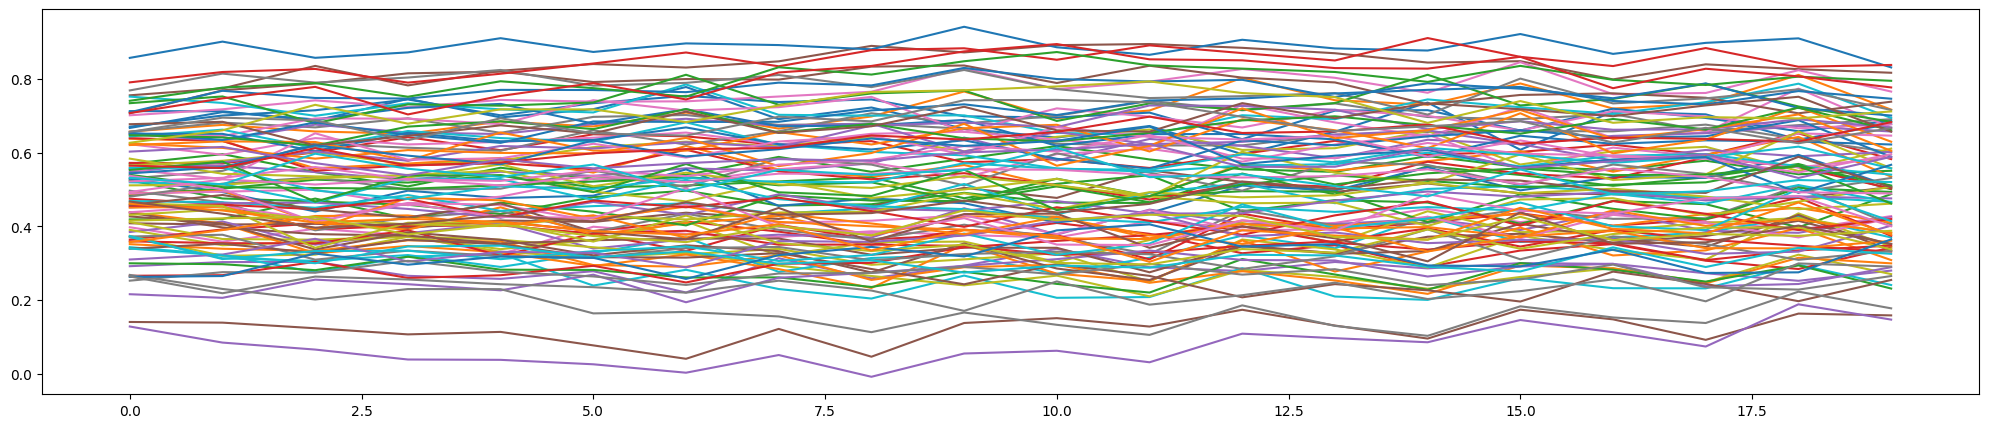

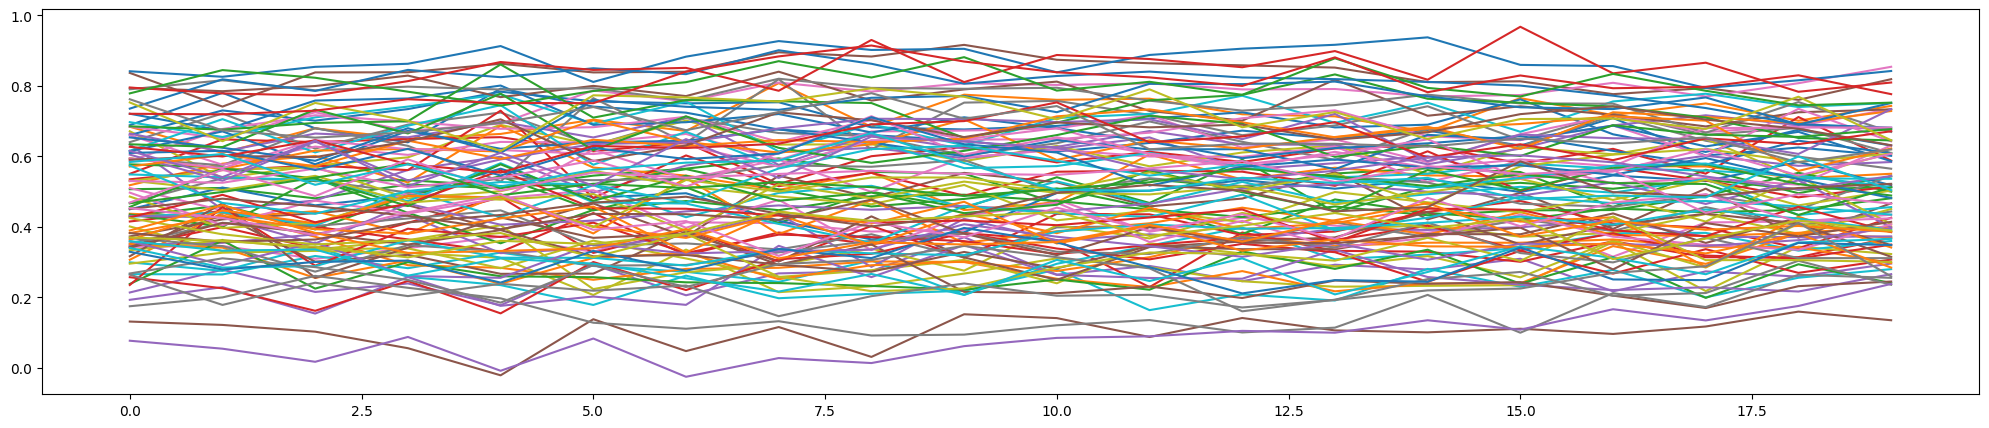

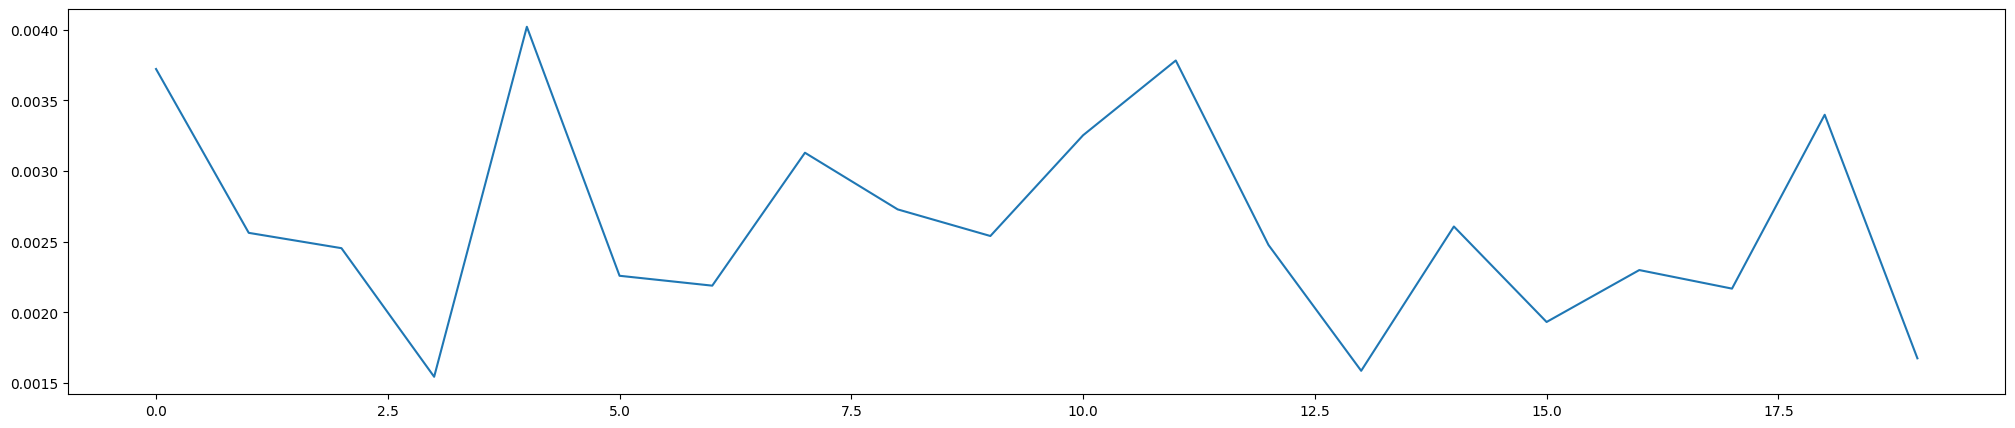

In [ ]:
plt.plot(ewf);
plt.figure()
plt.plot(np.concatenate([y_val,y_test])[0:20]);
print(np.mean(ewf - np.concatenate([y_val,y_test])[0:20], axis=0).shape)
plt.figure()
plt.plot(np.mean((ewf - np.concatenate([y_val,y_test])[0:20])**2, axis=1))